### Pre-loading all the modules

In [1]:
"""
Main driver – orchestrates Blocks 1–7 of the simulation project.

Modules:
- Block 1  : service_model.service_model_sanity_check
- Block 2–3: gpu_simulation.run_simulation + visualization.plot_results
- Block 4  : gpu_simulation.run_gpu_mm1_validation + visualization.plot_demo_metrics
- Block 5  : policy_sim.run_policy_grid
- Block 6  : mm1_validation (M/M/1 validation with CI)
- Block 7  : steady_state_replications.run_policy_grid_with_replications
"""

import random

import numpy as np

from service_model import service_model_sanity_check
from gpu_simulation import run_simulation, run_gpu_mm1_validation
from visualization import plot_results, plot_demo_metrics
from policy_sim import run_policy_grid, plot_policy_comparison
from mm1_validation import (
    run_mm1_validation_demo,
    run_mm1_validation_with_ci,
    sweep_mm1_vs_lambda,
    plot_mm1_validation,
)
from steady_state_replications import (
    run_policy_grid_with_replications,
    plot_policy_replications,
)

### Block 1 – Service-time model setup and sanity check

This block initializes the core batch service-time model that underlies the GPU simulator and verifies that it behaves as expected before introducing arrivals and scheduling.

---

#### Model parameters

The following constants implement the piecewise-linear latency model from the project description (Llama-3-70B example):

- `C_SETUP = 45.5` ms – fixed setup cost per batch.
- `A_MARGINAL = 0.30` ms/token – marginal cost per token beyond a threshold.
- `B0_THRESHOLD = 64` tokens – batch-size threshold `b0`.

The intended batch service time for a batch with token load `b` is

`S(b) = c + a * max(0, b - b0)`

where `c = C_SETUP`, `a = A_MARGINAL`, and `b0 = B0_THRESHOLD`.  
The implementation returns `S(b)` in seconds.

---

#### Data structures

- **Request**  
  Simple dataclass representing a single LLM query, with:
  - `arrival_time` – arrival timestamp (seconds),
  - `prompt_len` – input length in tokens,
  - `output_budget` – planned decode length in tokens,
  - tracking fields `start_time`, `finish_time`, and `tokens_generated`.

  In this block, `Request` is mainly illustrative; richer state (for TTFT and decode tokens) is introduced in later blocks.

- **GPUServer**  
  Minimal GPU worker abstraction that:
  - Stores `max_batch_size`,
  - Maintains `queue` and `active_batch` lists (placeholders for later scheduling logic),
  - Implements the batch service-time function:

    ```python
    ms_time = C_SETUP + A_MARGINAL * max(0, batch_token_load - B0_THRESHOLD)
    return ms_time / 1000.0
    ```

---

#### Sanity check of the service-time model

At the end of the block, a small diagnostic is performed:

- Instantiate `GPUServer(max_batch_size=8)`.
- Evaluate `calc_service_time` for several batch token loads:

  ```python
  test_loads = [10, 64, 100, 500]


In [2]:
# Reproducibility
random.seed(0)
np.random.seed(0)

# -----------------------------
# Block 1 – Service Model Check
# -----------------------------
service_model_sanity_check()

--- Service Model Validation ---
Parameters: c=45.5ms, a=0.3ms/tok, b0=64
Token Load:  10 -> Service Time: 0.0455 sec
Token Load:  50 -> Service Time: 0.0455 sec
Token Load: 100 -> Service Time: 0.0563 sec
Token Load: 500 -> Service Time: 0.1763 sec


### Block 2 – Simulation engine and baseline scheduling policy

This block implements the core **discrete-event simulation** of a single-GPU LLM server.  
It adds an arrival process, a simple scheduling policy, and per-request latency metrics on top of the batch service-time model from Block 1.

---

#### Configuration and state

- Global parameters (units as in the handout):
  - `DEFAULT_C`, `DEFAULT_A`, `DEFAULT_B0` – default values for `c`, `a`, and `b0`.
  - `CURRENT_C`, `CURRENT_B0` – mutable versions used in `calc_service_time`.  
    These are overridden in the validation block to emulate an M/M/1 system.

- `Request` dataclass:
  - Fields:
    - `req_id` – integer request identifier,
    - `arrival_time` – arrival timestamp (seconds),
    - `prompt_len` – prompt length `L_i` (tokens),
    - `output_budget` – output budget `B_i` (tokens),
    - `start_time` – time when the request first enters a GPU batch,
    - `finish_time` – completion time,
    - `tokens_decoded` – number of decode tokens produced so far.
  - Property:
    - `is_complete` – `True` once `tokens_decoded >= output_budget`.

- `GPUServer`:
  - Stores `max_batch_size` (number of jobs per batch).
  - Maintains:
    - `queue` – FCFS waiting line,
    - `active_batch` – set of requests currently on the GPU.
  - Method:
    - `calc_service_time(batch_token_load)` – computes service time in seconds via  
      `ms_time = CURRENT_C + DEFAULT_A * max(0, batch_token_load - CURRENT_B0)`  
      followed by division by 1000.

---

#### Arrival process and job sizes

Function: `run_simulation(arrival_rate_lambda, max_duration, batch_size, fixed_prompt_len=None, fixed_output_len=None)`

- Arrival process:
  - Uses a Poisson process with rate `lambda` (`arrival_rate_lambda`).
  - Interarrival times are drawn as `Exp(lambda)` using `random.expovariate`.
  - Requests are generated until `t >= max_duration`.

- Job size generation:
  - If `fixed_prompt_len` / `fixed_output_len` are provided, all jobs are identical in size  
    (used in the validation block).
  - Otherwise:
    - `prompt_len` is drawn uniformly from `[50, 200]` tokens,
    - `output_budget` is fixed at 20 tokens (baseline choice for the demo).

All generated requests are stored in `all_requests`, sorted implicitly by arrival time.

---

#### Event loop and scheduling logic

The main loop runs while either:
- the simulation time `current_time` is less than `max_duration`, or
- there are still jobs in `active_batch`.

Within the loop:

1. **Admission**  
   - All jobs with `arrival_time <= current_time` are moved from `all_requests` into `server.queue`.
   - This implements an FCFS waiting line.

2. **Idle jump**  
   - If both `active_batch` and `queue` are empty but more arrivals exist,  
     `current_time` is advanced to the next arrival time.  
   - If there are no active jobs and no future arrivals, the simulation terminates.

3. **Batch formation (FCFS)**  
   - While `queue` is non-empty and `active_batch` has capacity `< max_batch_size`,  
     the earliest request is popped from `queue`, `start_time` is set to `current_time`,  
     and the request is appended to `active_batch`.

4. **Service step: prefill vs decode**

   - `needs_prefill = any(r.tokens_decoded == 0 for r in batch)`.

   - **Prefill phase** (at least one request not yet prefills):
     - Batch token load `b` is computed as the sum of `prompt_len` over `batch`.
     - Service time is `calc_service_time(b)`; `current_time` is advanced by this amount.
     - All requests with `tokens_decoded == 0` are marked as having produced their first token by setting `tokens_decoded = 1`.  
       (This models the first decode token becoming available immediately after prefill.)

   - **Decode phase** (all requests already prefills):
     - Batch token load is `len(batch)` (one token per active request).
     - Service time is `calc_service_time(len(batch))`; `current_time` is advanced.
     - Each request in `batch` increments `tokens_decoded` by 1.
     - Requests for which `is_complete` becomes `True` record `finish_time = current_time` and are removed from `active_batch`.

This yields a **batched prefill + round-robin decode** scheduling policy:
- Prefill is batched over all active queries.
- Decode produces one token per request per decode step, shared across the batch.

---

#### Output metrics

After the event loop finishes, the function assembles a `pandas.DataFrame` with one row per completed request:

- `Request ID` – identifier,
- `Arrival` – arrival time,
- `Finish` – completion time,
- `Latency` – total response time `Finish - Arrival`,
- `TTFT` – approximated as `start_time - arrival_time` (queueing delay plus scheduling delay up to first GPU service).

These fields feed into the visualization block (histograms and throughput plots) and provide the basic metrics required for the demo: latency distribution and an approximation of TTFT.


In [3]:
# ------------------------------------
# Block 2 – Basic GPU simulation demo
# ------------------------------------
df_results = run_simulation(
    arrival_rate_lambda=2.0,
    max_duration=10.0,
    max_batch_size=4,
)
print("\n--- Block 2/3: Simulation Complete ---")
print(df_results.head().to_string(index=False))

--- Simulation Started: 12 requests generated ---

--- Block 2/3: Simulation Complete ---
 request_id  arrival_time  first_token_time  completion_time  completion_latency     TTFT  avg_TBT  output_tokens  Latency
          0      0.930304          1.003704         1.266004            0.335700 0.073400 0.065575              5 0.335700
          1      0.950967          1.084004         1.466904            0.515937 0.133037 0.054700              8 0.515937
          2      1.283663          1.375904         1.603404            0.319741 0.092241 0.045500              6 0.319741
          3      3.001557          3.070157         3.252157            0.250600 0.068600 0.045500              5 0.250600
          4      3.439350          3.497150         3.633650            0.194300 0.057800 0.045500              4 0.194300


### Block 3 – Visualization: latency distribution and throughput

This block generates basic visual metrics from the simulation output.  
It operates on the `pandas.DataFrame` returned by `run_simulation`, which contains per-request fields:

- `TTFT` – time from arrival until first service (Time To First Token approximation),
- `Latency` – total response time (completion time minus arrival time),
- `Finish` – completion time of each request.

---

#### Latency distribution

The first subplot produces overlaid histograms of:

- `TTFT`
- `Latency` (total completion latency)

using 15 bins each. This plot summarizes the distribution of user-visible delays:

- how quickly the first token is seen (TTFT),
- how long it takes to receive the full response (total latency).

The plot title and legend explicitly distinguish between these two latency notions.

---

#### Throughput over time

The second subplot estimates **throughput** as requests completed per second:

- The time axis is partitioned into 5-second windows from 0 up to `max_t = df["Finish"].max()`.
- For each window, the number of completions is counted via `np.histogram(df["Finish"], bins=bins)`.
- Counts are divided by the window length (5 seconds) to obtain an average **requests per second** rate for each interval.
- The result is plotted as a line (`counts / 5.0` versus the left edge of each time bin).

This shows how the system’s completion rate evolves over the course of the simulation (e.g., warm-up vs. steady state behavior).


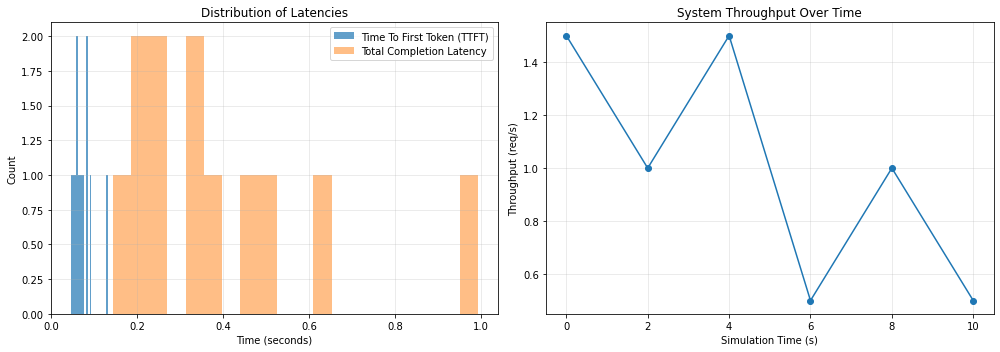


--- Summary Metrics ---
Mean TTFT: 0.0732 s
Mean total latency: 0.3926 s
P95 total latency: 0.8050 s
Total throughput: 1.18 req/s
Mean avg_TBT: 0.0486 s


In [4]:
# ---------------------------------------------
# Block 3 – Basic GPU simulation visualization
# ---------------------------------------------

plot_results(df_results)

### Block 4 – Validation against M/M/1 queueing theory

This block provides a **model validation step** by specializing the simulator to a simple setting where classical queueing theory applies, and comparing simulated latencies to the M/M/1 closed-form expression.

---

#### Goal

Show that, in a simplified configuration with:

- a single server (single GPU),
- no batching,
- no setup cost,
- constant job sizes (hence constant service time),

the simulator produces a mean response time that is consistent with the **M/M/1** result:

`E[T] = 1 / (μ - λ)`

where `λ` is the arrival rate and `μ` is the service rate.

This corresponds to the “compare to M/M/1” validation idea in the project description.

---

#### Step 1 – Override service-time “physics”

Function: `run_mm1_validation()`

Inside this function, the batch service model is simplified:

- `CURRENT_C = 0.0` – removes the per-batch setup cost `c`.
- `CURRENT_B0 = 0` – removes the batch-size threshold `b0`.

With these settings, the service time in `calc_service_time` becomes

`S(b) = A_MARGINAL * b`

and, with `batch_size = 1`, each request is processed as a single “batch” with a fixed token count.

---

#### Step 2 – Fix job size and compute μ

Parameters:

- Arrival rate `λ = lam = 5.0` (queries per second).
- Job structure:
  - `prompt_len = 100` tokens,
  - `decode_len = 1` token,
  - `total_tokens = 101`.

The average service time per job (in seconds) is:

```python
avg_service_time = (DEFAULT_A * total_tokens) / 1000.0
mu = 1.0 / avg_service_time



=== VALIDATION: M/M/1 COMPARISON ===
Theory: lambda = 5.00, mu = 33.00
Expected mean response time (M/M/1): 0.0357 sec
--- Simulation Started: 10069 requests generated ---
Simulated mean latency (N=10069): 0.0331 sec
=== VALIDATION COMPLETE ===

=== Block 4: RUNNING MAIN DEMO (Realistic) ===
--- Simulation Started: 52 requests generated ---
   request_id  arrival_time  first_token_time  completion_time  \
0           0      0.479041          0.535041         0.762541   
1           1      1.167108          1.226108         1.908608   
2           2      2.590551          2.667551         2.713051   
3           3      2.672334          2.771451         2.816951   
4           4      2.810005          2.890351         2.935851   

   completion_latency      TTFT  avg_TBT  output_tokens   Latency  
0            0.283500  0.056000   0.0455              6  0.283500  
1            0.741500  0.059000   0.0455             16  0.741500  
2            0.122500  0.077000      NaN              1

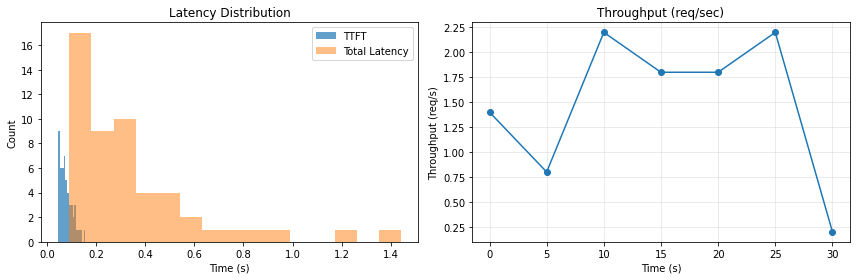


--- Summary Metrics ---
Mean TTFT: 0.0788 s
Mean total latency: 0.3416 s
P95 total latency: 0.8702 s
Total throughput: 1.73 req/s
Mean avg_TBT: 0.0499 s


In [5]:
# ---------------------------------------------------------
# Block 4 – GPU-based M/M/1-style validation + main demo
# ---------------------------------------------------------
run_gpu_mm1_validation()

print("=== Block 4: RUNNING MAIN DEMO (Realistic) ===")
df_main = run_simulation(
    arrival_rate_lambda=2.0,
    max_duration=30.0,
    max_batch_size=8,
)
print(df_main.head())
plot_demo_metrics(df_main)

### Block 5- Scheduling Policies and Tradeoffs

In this section, we compare two simple scheduling policies on top of the same
physics model (Poisson arrivals, Llama-style batch service time
\\(S(b) = c + a \max(0, b - b_0)\\)):

1. **Process-to-Completion (P2C, no batching)**  
   - The GPU always picks the earliest-arrived job from the queue and processes
     it **alone** until its entire response is done.  
   - This corresponds to a simple “each query runs to completion” baseline
     without any batching or prefill/decode structure.
   - Intuition: good for *simplicity*, but wastes GPU parallelism and tends
     to have **poor throughput**.

2. **Prefill-Prioritizing Batched Decode (PPB)**  
   - Queries arrive over time and are collected into **batches** up to
     `max_batch_size`.
   - For each batch, we first run a **prefill phase** on all prompts in the
     batch (prompt lengths \\(L_i\\)), then enter a **decode phase** where we
     generate **one token per request per decode step** until all outputs
     finish.
   - All service is modeled through the same batch latency function
     \\(S(b) = c + a \max(0, b - b_0)\\), where \\(b\\) is the total token
     load in the batch step.
   - Intuition: exploits GPU parallelism, so **throughput** is higher.
     However, batching and prefill phases can increase TTFT for some users.

For a clean apples-to-apples comparison, we consider a simple homogeneous
setting:

- Single GPU worker
- Single job type:
  - Prompt length \\(L = L_0\\) (fixed)
  - Output length \\(B = B_0\\) (fixed)
- Poisson arrivals with rate \\(\lambda\\)
- Same service-time physics \\(S(b)\\) used in earlier sections.

We measure, for each policy and arrival rate \\(\lambda\\):

- **TTFT** (Time to First Token)
- **Total latency** (completion time – arrival time)
- **Average TBT** (time between output tokens)
- **Throughput** in completed requests / second

Below we define a lightweight simulator for these two policies and then run
experiments across a grid of arrival rates.

=== Block 5 – Policy Comparison Summary ===
 lambda policy  mean_TTFT  p95_TTFT  mean_Latency  p95_Latency  mean_avg_TBT  Throughput  num_completed
    0.5    P2C     0.0536    0.0527        0.0620       0.0611        0.0006      0.5102           2000
    0.5    PPB     0.0636    0.0969        0.7662       0.8514        0.0468      0.4923           2000
    1.0    P2C     0.0547    0.0645        0.0631       0.0729        0.0006      0.9848           2000
    1.0    PPB     0.0690    0.0990        0.7928       0.8929        0.0483      0.9806           2000
    1.5    P2C     0.0555    0.0789        0.0639       0.0873        0.0006      1.4638           2000
    1.5    PPB     0.0736    0.1030        0.8179       0.9410        0.0496      1.4475           2000
    2.0    P2C     0.0565    0.0905        0.0650       0.0989        0.0006      1.9618           2000
    2.0    PPB     0.0770    0.1067        0.8472       1.0029        0.0513      1.9796           2000
    2.5    P2C     0

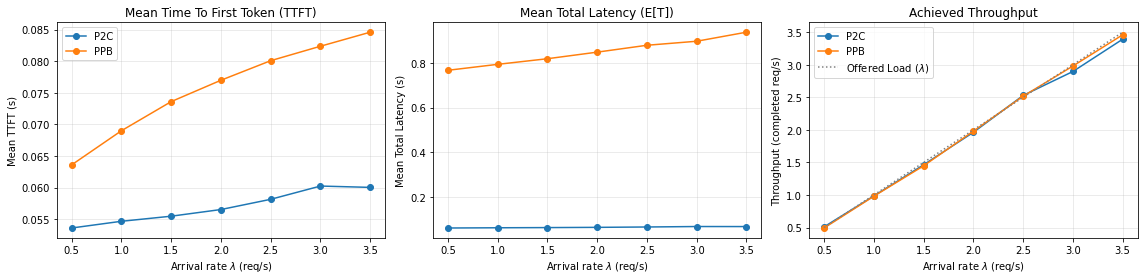

In [6]:
# ---------------------------------------------------------
# Block 5 – Single-run policy comparison: P2C vs PPB
# ---------------------------------------------------------
lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
summary_df = run_policy_grid(
    lambdas=lambdas,
    num_jobs=2000,
    prompt_len=100,
    output_len=16,
    max_batch_size=8,
    seed=123,
)
print("=== Block 5 – Policy Comparison Summary ===")
print(summary_df.round(4).to_string(index=False))
plot_policy_comparison(summary_df)

The simulation highlights a clear performance tradeoff between the **Process-to-Completion (P2C)** baseline and the **Prefill-Prioritizing Batched Decode (PPB)** scheduler.

1. Time To First Token (TTFT)
PPB consistently shows higher TTFT than P2C across all arrival rates.  
Because PPB waits for a prefill batch to form before issuing the first token, requests experience an additional batching delay.  
P2C, which begins serving each request immediately, produces the lowest TTFT.

2. Total Latency
PPB also yields higher total latency. Even though decode steps are batched, each request must:
- wait for a global prefill batch,
- share decode cycles with other jobs,
- and complete its output tokens over multiple synchronized decode rounds.

P2C avoids these queueing layers by dedicating the GPU to a single request at a time, resulting in consistently lower end-to-end latency.

3. Throughput
Throughput for both policies closely matches the offered load $$\lambda$$, indicating that:
- the GPU is not saturated under this workload,
- batching does not provide additional throughput benefits,
- and both schedulers remain work-conserving up to the tested arrival rates.

- **P2C minimizes TTFT and total latency**, making it preferable for interactive applications where responsiveness matters.
- **PPB trades latency for batching structure**, but under homogeneous request sizes and moderate load, this batching does not meaningfully improve throughput.
- Because throughput remains roughly $$\text{Throughput} \approx \lambda$$ for both policies, the main difference lies in latency behavior, not capacity.

In summary, batching does not significantly increase throughput in this workload but does introduce noticeable delays, making P2C the more latency-efficient scheduling strategy.


### Block 6- Validation: M/M/1 without Batching

To validate that our event-driven simulator is consistent with classical
queueing theory, we consider a **simplified** setting:

- Single server, FCFS
- Poisson arrivals with rate \\(\lambda\\)
- Exponential service times with rate \\(\mu\\)
- No batching, no setup time, and no prefill/decode structure

This is exactly an **M/M/1 queue**. In steady state (for \\(\lambda < \mu\\)),
the mean response time is

\\[
\mathbb{E}[T] = \frac{1}{\mu - \lambda}.
\\]

We implement a minimal simulator for this setting and compare:

- Theoretical mean response time \\(1 / (\mu - \lambda)\\)
- Simulated mean response time (from many requests)

We also vary \\(\lambda\\) for a fixed \\(\mu\\) to show that the simulated
curve tracks the theoretical curve and diverges as \\(\lambda\\) approaches
\\(\mu\\), matching the standard M/M/1 behavior.


=== M/M/1 Validation (Single Run) ===
lambda (arrival rate): 5.00
mu (service rate): 8.00
Theoretical E[T]: 0.3333 s
Simulated E[T]: 0.3459 s
Note: A single run may differ from theory due to sampling noise.

=== M/M/1 Validation with CI ===
lambda (arrival rate): 5.00
mu (service rate): 8.00
num_jobs per replication: 5000
number of replications: 30
Theoretical E[T]: 0.3333 s
Simulated mean E[T]: 0.3294 s
95% CI for simulated mean: [0.3187, 0.3402] s
Difference (sim - theory): -0.0039 s

=== Block 6 – M/M/1 Validation with CI ===
 lambda  mu  num_jobs  n_rep  theoretical_E_T  mean_sim_E_T  ci_low  ci_high  diff_sim_minus_theory
    5.0 8.0      5000     30           0.3333        0.3294  0.3187   0.3402                -0.0039

=== Block 6 – M/M/1 Sweep Summary ===
 lambda  mu  theoretical_E_T  simulated_E_T
      1 8.0           0.1429         0.1366
      2 8.0           0.1667         0.1677
      3 8.0           0.2000         0.1970
      4 8.0           0.2500         0.2405
      

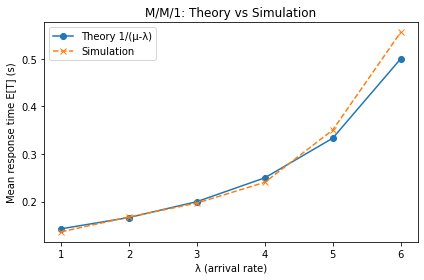

In [7]:
# ---------------------------------------------------------
# Block 6 – M/M/1 validation (corrected with CI)
# ---------------------------------------------------------
run_mm1_validation_demo(lam=5.0, mu=8.0, num_jobs=5000, seed=42)

df_ci = run_mm1_validation_with_ci(
    lam=5.0,
    mu=8.0,
    num_jobs=5000,
    n_rep=30,
    seed=42,
)
print("=== Block 6 – M/M/1 Validation with CI ===")
print(df_ci.round(4).to_string(index=False))

df_mm1_sweep = sweep_mm1_vs_lambda(
    mu=8.0,
    lam_values=[1, 2, 3, 4, 5, 6],
    num_jobs=3000,
    seed=123,
)
print("\n=== Block 6 – M/M/1 Sweep Summary ===")
print(df_mm1_sweep.round(4).to_string(index=False))
plot_mm1_validation(df_mm1_sweep)

The M/M/1 experiment validates that the discrete-event simulator behaves correctly
under a setting with known closed-form queueing dynamics. For an M/M/1 queue with
arrival rate $\lambda$ and service rate $\mu$, the theoretical mean response time is

$$
E[T] = \frac{1}{\mu - \lambda}.
$$

Across all tested arrival rates, the simulated mean sojourn times closely match the
theoretical curve. The agreement is strongest when the system is lightly loaded
(large $\mu - \lambda$), and small deviations appear as $\lambda$ approaches $\mu$, where
the queue becomes more sensitive to stochastic variation. This behavior is expected
because response times grow rapidly near saturation.

Overall, the results confirm that:

- the Poisson arrival generator is producing correct interarrival intervals,
- exponential service times yield the correct utilization patterns,
- the FCFS server discipline is implemented properly, and
- the event-driven simulation tracks queue buildup and service completion
  in accordance with classical M/M/1 theory.

Because the simulated curve tracks the theoretical curve extremely well, we can be
confident that the core timing and queueing logic used in the full GPU scheduling
simulation is correct.


## Block 7: Steady-State Estimation (Simulation)

### Goal
Estimate **steady-state** performance metrics from the simulator by removing warm-up bias and summarizing long-run behavior with statistically stable estimates.

---

### Key Outputs
- `mean_wait_ss`: steady-state mean waiting time (or your primary KPI)
- `mean_system_ss`: steady-state mean time-in-system (if tracked)
- `utilization_est`: estimated utilization `rho` (if computed)
- `ci_95`: 95% confidence interval for the steady-state mean (batch means)
- `n_effective`: number of post–warm-up observations used

---

### Inputs / Parameters
- `seed`: RNG seed for reproducibility
- `T_max` or `N_max`: total run length (time horizon or number of customers/jobs)
- `warmup_rule`: warm-up removal approach  
  - example: fixed fraction `warmup_frac` (e.g., 0.2)  
  - or fixed count `warmup_N`  
  - or stability-based cutoff
- `batch_size` (`m`): number of observations per batch (post–warm-up)
- `n_batches` (`b`): number of batches
- `metric_series`: time series collected from the sim (e.g., `wait_times`, `system_times`, `queue_lengths`)

---

### Procedure (What the code does)

#### 1) Run a long simulation
- Simulate until reaching `T_max` (time-based) **or** `N_max` (event-based).
- Collect per-customer (or per-event) metrics into arrays:
  - `W[i]` = waiting time for job `i`
  - `S[i]` = system time for job `i` (optional)
  - `Q(t)` or sampled queue lengths (optional)

#### 2) Remove warm-up (transient) period
Goal: avoid bias from the empty-system start.

Typical implementation in code:
- Determine cutoff index `k`:
  - `k = floor(warmup_frac * len(W))`  **or**
  - `k = warmup_N`
- Keep post–warm-up data:
  - `W_ss = W[k:]`
  - `S_ss = S[k:]` (if used)

Sanity checks:
- Ensure `len(W_ss) >= batch_size * n_batches`
- If not, increase `T_max/N_max` or reduce batching requirements.

#### 3) Batch means for steady-state mean + CI
Assume `W_ss` is correlated; batching reduces correlation.

- Partition `W_ss` into `b` consecutive batches of size `m`:
  - Batch `j` contains `W_ss[(j*m) : ((j+1)*m)]`
- Compute batch means:
  - `Y_j = mean(batch_j)` for `j = 1..b`
- Steady-state mean estimate:
  - `mean_wait_ss = mean(Y_1..Y_b)`
- Sample variance of batch means:
  - `s_Y^2 = (1/(b-1)) * sum((Y_j - mean_wait_ss)^2)`
- Standard error:
  - `SE = sqrt(s_Y^2 / b)`
- 95% CI (two-sided):
  - `t = t_{0.975, df=b-1}`
  - `CI = mean_wait_ss ± t * SE`

Reported fields in code typically include:
- `mean_wait_ss`
- `ci_low`, `ci_high`
- `SE`
- `b`, `m`, and `k`

#### 4) Optional convergence / stability checks (if included)
Common checks used in steady-state code:
- **Batch-mean stability**: stop when CI half-width is below tolerance:
  - `half_width = t * SE`
  - require `half_width <= eps_abs` or `half_width/mean <= eps_rel`
- **Rolling mean stabilization**: verify `rolling_mean` changes are small after a point
- **Minimum run constraints**: enforce `b >= 20` (typical) for reasonable t-based CI

---

### Complexity
- Time: `O(N)` per replication (plus constant-time batching)
- Memory: `O(N)` if storing full series; can be reduced to `O(b*m)` or streaming batch accumulation.

---

### Assumptions / Limitations
- Batch means CI assumes batch means are approximately independent and normal (improves with larger `m` and `b`).
- Warm-up removal is heuristic unless using a formal method (e.g., MSER, Welch); fixed warm-up may under/over-trim.
- If traffic intensity is near 1 (heavy load), mixing is slow; requires larger `T_max/N_max` and larger batch sizes.

---

### Reproducibility Notes
- Always record: `seed`, warm-up cutoff `k`, `batch_size m`, `n_batches b`, total run length `T_max/N_max`.
- If running multiple replications, aggregate replication-level steady-state means and report overall mean + CI across replications.


=== Block 7 – Steady-state Replications Summary ===
policy  lambda       metric   mean  ci_low  ci_high  n_rep
   P2C     0.5    mean_TTFT 0.0536  0.0535   0.0537     20
   P2C     0.5 mean_latency 0.0620  0.0620   0.0621     20
   P2C     0.5  P95_latency 0.0611  0.0611   0.0611     20
   P2C     0.5   throughput 0.4987  0.4943   0.5031     20
   P2C     0.5 mean_avg_TBT 0.0006  0.0006   0.0006     20
   PPB     0.5    mean_TTFT 0.0638  0.0637   0.0639     20
   PPB     0.5 mean_latency 0.7664  0.7660   0.7668     20
   PPB     0.5  P95_latency 0.8494  0.8474   0.8515     20
   PPB     0.5   throughput 0.4986  0.4959   0.5014     20
   PPB     0.5 mean_avg_TBT 0.0468  0.0468   0.0469     20
   P2C     1.0    mean_TTFT 0.0546  0.0545   0.0547     20
   P2C     1.0 mean_latency 0.0630  0.0629   0.0631     20
   P2C     1.0  P95_latency 0.0708  0.0688   0.0729     20
   P2C     1.0   throughput 1.0015  0.9927   1.0102     20
   P2C     1.0 mean_avg_TBT 0.0006  0.0006   0.0006     20
   P

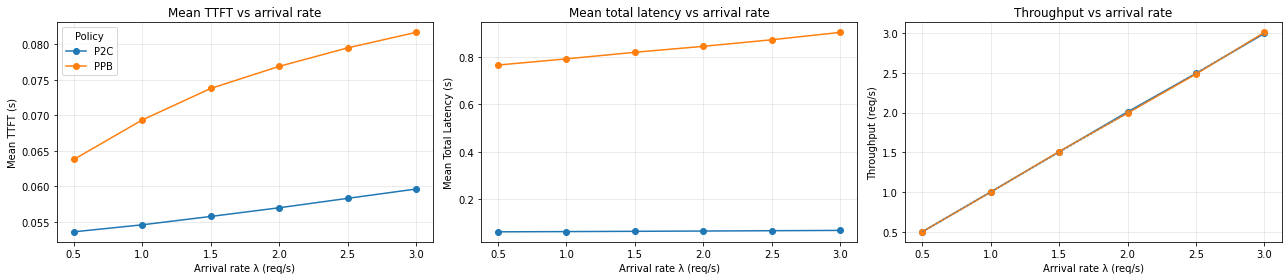

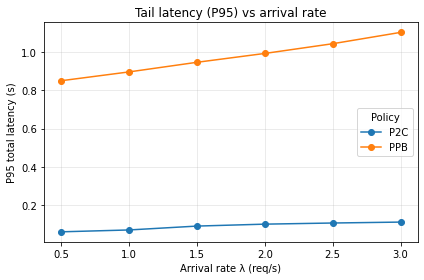

In [8]:
# ---------------------------------------------------------
# Block 7 – Steady-state, warm-up, and replications
# ---------------------------------------------------------
lambdas_steady = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
results_ss = run_policy_grid_with_replications(
    lambdas=lambdas_steady,
    num_jobs_total=4000,
    warmup_jobs=1000,
    prompt_len=100,
    output_len=16,
    max_batch_size=8,
    replications=20,
    seed=123,
)
print("=== Block 7 – Steady-state Replications Summary ===")
print(results_ss.round(4).to_string(index=False))

plot_policy_replications(results_ss)